# 1 Bowtie Structure of Non-Web Networks

In [1]:
import snap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load graphs
Epinions = snap.LoadEdgeList(snap.PNGraph, "soc-Epinions1.txt", 0, 1)
Email = snap.LoadEdgeList(snap.PNGraph, "email-EuAll.txt", 0, 1)

## 1.1 Node Position

In [3]:
def node_position(Graph, Idx):
    print('Number of nodes in Graph:', Graph.GetNodes())
    
    # largest strongly conencted component
    MxScc = snap.GetMxScc(Graph)
    SCC = {n.GetId() for n in MxScc.Nodes()}
    print('Number of nodes in Largest SCC:', len(SCC))
    
    # in and out BFS
    InBfsTree = snap.GetBfsTree(Graph, Idx, False, True)
    InNodes = {n.GetId() for n in InBfsTree.Nodes()}
    OutBfsTree = snap.GetBfsTree(Graph, Idx, True, False)
    OutNodes = {n.GetId() for n in OutBfsTree.Nodes()}
    print('Number of nodes in in/out BFS tree: %d / %d' % (len(InNodes), len(OutNodes)))
    
    # whether in/out BFS tree include the largest SCC
    print('In BFS includes the largest SCC:', SCC.issubset(InNodes))
    print('Out BFS includes the largest SCC:', SCC.issubset(OutNodes))

### Email

In [4]:
node_position(Email, 2018)

Number of nodes in Graph: 265214
Number of nodes in Largest SCC: 34203
Number of nodes in in/out BFS tree: 1 / 52104
In BFS includes the largest SCC: False
Out BFS includes the largest SCC: True


Node 2018 has a large out BFS tree, which include the largest SCC. So node 2018 is in IN part of Bowtie structure. 

### Epinions

In [5]:
node_position(Epinions, 224)

Number of nodes in Graph: 75879
Number of nodes in Largest SCC: 32223
Number of nodes in in/out BFS tree: 56459 / 47676
In BFS includes the largest SCC: True
Out BFS includes the largest SCC: True


Node 224 has large in and out BFS tree, which both include the largest SCC. So node 224 is in SCC part of Bowtie structure. 

## 1.2 Random-start BFS

In [6]:
def reachability_plot(Graph, n_sample):
    Ins = []
    Outs = []
    for i in range(n_sample):
        Idx = Graph.GetRndNId()
        InBfsTree = snap.GetBfsTree(Graph, Idx, False, True)
        OutBfsTree = snap.GetBfsTree(Graph, Idx, True, False)
        Ins.append(InBfsTree.GetNodes())
        Outs.append(OutBfsTree.GetNodes())
        print('.', end='')
        
    Ins, Outs = sorted(Ins), sorted(Outs)
    
    title_dict = {'inlinks': Ins, 'outlinks': Outs}
    for name, data in title_dict.items():
        plt.plot(np.arange(0, 1, 1/n_sample), data, label=name)
    plt.yscale('log')
    plt.title('Reachability using')
    plt.xlabel('frac. of starting nodes')
    plt.ylabel('number of nodes reached')
    plt.legend(loc='upper left')
    plt.show()
    return sorted(Ins), sorted(Outs)

### Email

....................................................................................................

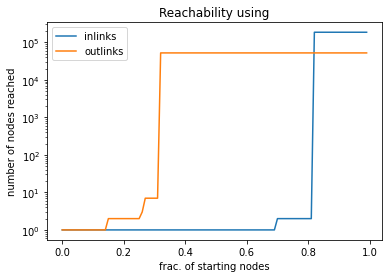

In [7]:
Ins, Outs = reachability_plot(Email, 100)

A larger fraction of node will reach SCC using outlinks than inlinks. So
$$
\text{IN} + \text{SCC} > \text{OUT} + \text{SCC} \to \text{IN} > \text{OUT}
$$

### Epinions

....................................................................................................

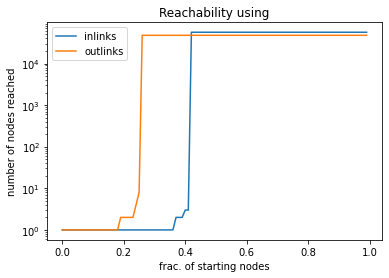

In [8]:
Ins, Outs = reachability_plot(Epinions, 100)

Similarly, we get $\text{IN}$ is marginally larger than $\text{OUT}$. 

## 1.3 Size of Bowtie Regions
First, we apply `GetMxScc` and `GetMxWcc` to get the largest strongly and weakly connected components. It is obvious that
$$
\begin{aligned}
\text{MxScc} &= \text{SCC} \\
\text{MxWcc} &= \text{SCC} + \text{IN} + \text{OUT} + \text{TENDRILS} + \text{TUBES}
\end{aligned}
$$
Then we pick a node in $\text{SCC}$, applying both in and out BFS. We could find that
$$
\begin{aligned}
\text{InNodes} &= \text{IN} + \text{SCC} \\
\text{OutNodes} &= \text{OUT} + \text{SCC}
\end{aligned}
$$
So 
$$
\text{IN} = \text{InNodes} - \text{MxScc} \\
\text{OUT} = \text{OutNodes} - \text{MxScc} \\
\text{TENDRILS} + \text{TUBES} = \text{MxWcc} - \text{InNodes} - \text{OutNodes} \\
$$
Note that here operator subtract means difference set.   
And finally $\text{DISCONNECTED} = \text{ALL} - \text{MxWcc}$

In [9]:
def bowtie_regions(Graph):
    ALL = {n.GetId() for n in Graph.Nodes()}
    
    # largest strongly conencted component
    MxScc = snap.GetMxScc(Graph)
    SCC = {n.GetId() for n in MxScc.Nodes()}
    MxWcc = snap.GetMxWcc(Graph)
    WCC = {n.GetId() for n in MxWcc.Nodes()}
    
    Idx = list(SCC)[0]  # select a node from SCC
    # in and out BFS
    InBfsTree = snap.GetBfsTree(Graph, Idx, False, True)
    InNodes = {n.GetId() for n in InBfsTree.Nodes()}
    OutBfsTree = snap.GetBfsTree(Graph, Idx, True, False)
    OutNodes = {n.GetId() for n in OutBfsTree.Nodes()}
    IN = InNodes - SCC
    OUT = OutNodes - SCC
    TENDRILS_TUBES = WCC - InNodes - OutNodes
    DISCONNECTED = ALL - WCC
    
    d = {
        'IN': IN, 
        'OUT': OUT, 
        'SCC': SCC, 
        'TENDRILS_TUBES': TENDRILS_TUBES,
        'DISCONNECTED': DISCONNECTED,
    }
    return d

### Email

In [10]:
d = bowtie_regions(Email)
for name, data in d.items():
    print('Number of nodes in %s: %d' % (name, len(data)))

Number of nodes in IN: 151023
Number of nodes in OUT: 17900
Number of nodes in SCC: 34203
Number of nodes in TENDRILS_TUBES: 21706
Number of nodes in DISCONNECTED: 40382


### Epinions

In [11]:
d = bowtie_regions(Epinions)
for name, data in d.items():
    print('Number of nodes in %s: %d' % (name, len(data)))

Number of nodes in IN: 24236
Number of nodes in OUT: 15453
Number of nodes in SCC: 32223
Number of nodes in TENDRILS_TUBES: 3965
Number of nodes in DISCONNECTED: 2


The results are coherent to our guess in 1.2

### 1.4 Probability of a Path Existing Between Two Randomly Chosen Nodes

Assume that there are relatively $p_\text{in}, p_\text{out}, p_\text{scc}$ fraction of nodes in the graph. There are 9 cases of choosing start node and finish node:  

| start | finish | result | probability |
|:----:|:----:|:----:|:----:|
| IN | IN | not sure | $p_\text{in}^2$ |
| IN | SCC | path | $p_\text{in} p_\text{scc}$ |
| IN | OUT | path | $p_\text{in} p_\text{out}$ |
| SCC | IN | no path| $p_\text{in} p_\text{scc}$ |
| SCC | SCC | path | $p_\text{scc}^2$ |
| SCC | OUT | path | $p_\text{scc} p_\text{out}$ |
| OUT | IN | no path | $p_\text{in} p_\text{out}$ |
| OUT | SCC | no path | $p_\text{scc} p_\text{out}$ |
| OUT | OUT | not sure | $p_\text{out}^2$ |

So the probability that there is a path is at least $(p_\text{in} + p_\text{scc})(p_\text{scc} + p_\text{out})$ (if there is no direct path between any two nodes in both IN and OUT), and at most $(p_\text{in} + p_\text{scc})(p_\text{scc} + p_\text{out}) + p_\text{in}^2 + p_\text{out}^2$ (if both IN and OUT are smaller SCC).  
Personally I guess the real probability is slightly larger than $(p_\text{in} + p_\text{scc})(p_\text{scc} + p_\text{out})$. 

We can actually verify that! 

In [12]:
def path_rate(Graph, n_sample=100, ignore=True):
    result = []
    d = bowtie_regions(Graph)
    region = d['IN'] | d['OUT'] | d['SCC']
    i = 0
    while i < n_sample:
        start = Graph.GetRndNId()
        finish = Graph.GetRndNId()
        if ignore and ((start not in region) or (finish not in region)):
            continue
        result.append(snap.GetShortPath(Graph, start, finish, True))
        i = i + 1
    return result

In [13]:
def expect_rate(Graph):
    d = bowtie_regions(Graph)
    region = d['IN'] | d['OUT'] | d['SCC']
    p_in = len(d['IN']) / len(d['IN'] | d['OUT'] | d['SCC'])
    p_out = len(d['OUT']) / len(d['IN'] | d['OUT'] | d['SCC'])
    p_scc = len(d['SCC']) / len(d['IN'] | d['OUT'] | d['SCC'])
    return (p_in + p_scc) * (p_scc + p_out)

### Email

In [14]:
result = path_rate(Email, n_sample=1000)
result = np.array(result) >= 0
rates = np.cumsum(result) / np.arange(1, 1001)  # real rate
expect = expect_rate(Email)
print('Expected rate:', expect)
print('Real rate:', rates[-1])

Expected rate: 0.23390184381693388
Real rate: 0.245


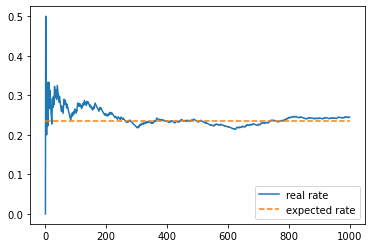

In [15]:
plt.plot(rates, label='real rate')
plt.plot([0, 1000], [expect, expect], '--', label='expected rate')
plt.legend(loc='lower right')
plt.show()

### Epinions

In [16]:
result = path_rate(Epinions, n_sample=1000)
result = np.array(result) >= 0
rates = np.cumsum(result) / np.arange(1, 1001)  # real rate
expect = expect_rate(Epinions)
print('Expected rate:', expect)
print('Real rate:', rates[-1])

Expected rate: 0.5205114147003642
Real rate: 0.533


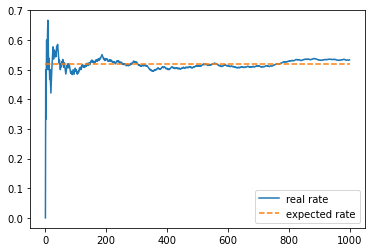

In [17]:
plt.plot(rates, label='real rate')
plt.plot([0, 1000], [expect, expect], '--', label='expected rate')
plt.legend(loc='lower right')
plt.show()

It shows that the fraction of reachable pairs will approxconverge to 